In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

In [2]:
def get_nc_data(infile, var):
    tmpgroup = nc.Dataset(infile, 'r', format='NETCDF4')
    outdata = tmpgroup.variables[var][:]
    tmpgroup.close()
    return outdata

## 0. data preparation functions

In [3]:
def get_raw_input_static(infile):
    
    DEM_fine = get_nc_data(infile, 'HGT_M')
    LU_fine = get_nc_data(infile, 'LU_INDEX')
    
    return DEM_fine, LU_fine

In [4]:
def rearrange_matrix_to_array_c(indata, f2c_row, f2c_col):
    # input: x, y
    # coarse resolution data
    nt = indata.shape[0]
    nt = 200
    nx, ny = f2c_row.shape[0:2]
    outdata = np.zeros((nt*landp_total))
    rowindex = np.reshape(f2c_row[landmask==1], (landp_total))
    colindex = np.reshape(f2c_col[landmask==1], (landp_total))
    for t in np.arange(nt):    
        outdata[(t*landp_total):(t*landp_total+landp_total)] = indata[t][rowindex, colindex]
        
    return outdata

In [5]:
def rearrange_matrix_to_array_land_f(indata, nt):
    # input: x, y
    # fine scale data
    nx, ny = indata.shape[0:2]
    nt = 200
    
    outdata = np.zeros((nt*landp_total))
    for t in np.arange(nt):
        outdata[(t*landp_total):(t*landp_total+landp_total)] = np.reshape(indata[landmask==1], (landp_total))
        
    return outdata

## 0.1 misc. functions. For plotting

In [6]:
def generate_map_index(nx, ny):
    xindex_matrix = np.zeros((nx, ny), dtype=int)
    yindex_matrix = np.zeros((nx, ny), dtype=int)
    for i in np.arange(nx):
        xindex_matrix[i,:] = np.ones(ny)*i
    for j in np.arange(ny):
        yindex_matrix[:,j] = np.ones(nx)*j
        
    return np.reshape(xindex_matrix[landmask==1], (landp_total)), np.reshape(yindex_matrix[landmask==1], (landp_total))

In [7]:
def recover_map_results(indata, xdata, ydata):
    outdata = np.zeros((450,450))*-9999
    
    outdata[xdata, ydata] = indata
    outdata[outdata==-9999] = np.nan
    
    return outdata

In [8]:
def crt_MeteoSwiss_colormap(cmapname):
    
    full_info = {'hotcold':['#181870', '#104e8b', '#1774cd', '#4876ff', '#5baced', '#add7e6', '#d1eded', '#e5eff9', '#f2ffff', '#ffffff', '#fdf5e6', '#ffe4b4', '#f3a460', '#ed7600', '#cd661d', '#e0310f', '#ed0000', '#cd0000', '#8b0000'],
                 'hotcolr':['#000032', '#181870', '#104e8b', '#1774cd', '#4876ff', '#5baced', '#add7e6', '#d1eded', '#e5eff9', '#f2ffff', '#fdf5e6', '#ffe4b4', '#f3a460', '#ed7600', '#cd661d', '#e0310f', '#ed0000', '#cd0000', '#8b0000', '#320000'],
                 'mch':['#ffffff', '#000000', '#202020', '#404040', '#606060', '#808080', '#a0a0a0', '#c0c0c0', '#e0e0e0', '#ff0000', '#00ff00', '#0000ff', '#ffff00', '#00ffff', '#ff00ff'],
                 'perc2':['#d7e3ee', '#b5caff', '#8fb3ff', '#7f97ff', '#abcf63', '#e8f59e', '#fffa14', '#ffd121', '#ffa30a', '#ff4c00'],
                 'percent':['#640096', '#2730d7', '#598dfc', '#8befd9', '#60cf91', '#1a9850', '#91cf60', '#d9ef8b', '#fee08b', '#fc8d59', '#d73027', '#960064'],
                 'precip1':['#ffffff', '#edfac2', '#cdffcd', '#99f0b2', '#53bd9f', '#32a696', '#3296b4', '#0570b0', '#05508c', '#0a1f96', '#2c0246', '#6a2c5a'],
                 'precip2_15':['#ffffff', '#640064', '#af00af', '#dc00dc', '#3232c8', '#0064ff', '#009696', '#00c832', '#64ff00', '#96ff00', '#c8ff32', '#ffff00', '#ffc800', '#ffa000', '#ff7d00', '#e11900'],
                 'precip2_17':['#ffffff', '#ebf6ff', '#d6e2ff', '#b5c9ff', '#8eb2ff', '#7f96ff', '#7285f8', '#6370f8', '#009e1e', '#3cbc3d', '#b3d16e', '#b9f96e', '#fff913', '#ffa309', '#e50000', '#bd0000', '#810000', '#000000'],
                 'precip3':['#ffffff', '#d6e2ff', '#b5c9ff', '#8eb2ff', '#7f96ff', '#6370f7', '#0063ff', '#009696', '#00c633', '#63ff00', '#96ff00', '#c6ff33', '#ffff00', '#ffc600', '#ffa000', '#ff7c00', '#ff1900'],
                 'precip4':['#fefefe', '#dffff9', '#9ad9ca', '#67c2a3', '#40ad75', '#32a696', '#5aa0cd', '#4292c7', '#4c8dc4', '#072f6b', '#071e46', '#4c0073'],
                 'precip4_diff':['#6b2107', '#b53b21', '#c75542', '#cd695a', '#a63237', '#ad4058', '#c26772', '#d99a9f', '#ffdfe0', '#fefefe', '#fefefe', '#dffff9', '#9ad9ca', '#67c2a3', '#40ad75', '#32a696', '#5aa0cd', '#4292c7', '#4c8dc4', '#072f6b'],
                 'precip1_diff_12':['#b66a28', '#cd853f', '#e1a564', '#f5cd84', '#f5e09e', '#fff5ba', '#ffffff', '#cdffcd', '#99f0b2', '#53bd9f', '#6eaac8', '#0570b0', '#023858'],
                 'precip1_diff_1':['#53bd9f', '#e1a564'],
                 'spread':['#ffffff', '#ffe1e1', '#ffd2d2', '#ffa5a5', '#ff7878', '#ff4b4b', '#ff0000', '#ff6400', '#ff9600', '#ffc800', '#ffff00', '#8cff00', '#00ff00', '#00cd5f', '#0091c8', '#0000ff'],
                 'sunshine':['#ffffff', '#fff5cc', '#ffe670', '#ffcc33', '#ffaf33', '#ff9933', '#ff6f33', '#ff5500', '#e6281e', '#c81e14'],
                 'sunshine_diff':['#510979', '#950fdf', '#b74bf3', '#cb7ef6', '#e1b4fa', '#ecd0fc', '#ffffff', '#fff5cc', '#ffe670', '#ffcc33', '#ffaf33', '#ff6f00', '#e6281e'],
                 't2m':['#6de3ff', '#aff0ff', '#ffc4e2', '#ff99cc', '#ff00ff', '#800080', '#000080', '#4646ff', '#3366ff', '#85a2ff', '#ffffff', '#cccccc', '#b3b3b3', '#999999', '#606060', '#808000', '#005c00', '#008000', '#339966', '#9dd500', '#d4ff5b', '#ffff00', '#ffb870', '#ff9900', '#ff6600', '#ff0000', '#bc4b00', '#ab0038', '#800000', '#a370ff'],
                 'temp':['#071e46', '#072f6b', '#08529c', '#2171b5', '#4292c7', '#5aa0cd', '#78bfd6', '#aadce6', '#dbf5ff', '#f0fcff', '#fff0f5', '#ffe0e0', '#fcbbaa', '#fc9272', '#fb6a4a', '#f03c2b', '#cc181e', '#a60f14', '#780a0f', '#5f0000'],
                 'temp_diff_18':['#071e46', '#072f6b', '#08579c', '#2171b5', '#4292c7', '#5aa0cd', '#78bfd6', '#aadce6', '#dbf5ff', '#ffffff', '#ffe0e0', '#fcbbaa', '#fc9272', '#fb6a4a', '#f03c2b', '#cc181e', '#a60f14', '#780a0f', '#5f0000'],
                 'temp_diff_1':['#f03c2b', '#2171b5'],
                 'topo':['#28369a', '#00c932', '#1ed368', '#5ee074', '#a2eb82', '#dff892', '#f6e595', '#c8b276', '#a27e5e', '#8f6154', '#a27d74', '#b2968b', '#c7b0aa', '#dbcdca', '#ece4e2', '#ffffff'],
                 'wind':['#ffffff', '#eff4d1', '#e8f49e', '#aace63', '#e2ed16', '#ffed00', '#ffed82', '#f4d17f', '#eda549', '#e58c3d', '#db7c3d', '#ef073d', '#e856a3', '#9b70a8', '#6370f7', '#7f96ff', '#8eb2ff', '#b5c9ff'],
                 'demo':'Here is a list of the colormaps:\n  hotcold\n  hotcolr\n  mch\n  perc2\n  percent\n  precip1\n  precip2_15\n  precip2_17\n  precip3\n  precip4\n  precip4_diff\n  precip_diff_12\n  precip_diff_1\n  spread\n  sunshine\n  sunshine_diff\n  t2m\n  temp\n  temp_diff_18\n  temp_diff_1\n  topo\n  wind',
                }
    if cmapname=='demo':
        print(full_info.get('demo'))
    else:
        return matplotlib.colors.ListedColormap(full_info.get(cmapname))

#### static data

In [9]:
f2c_row = np.zeros((450,450), dtype=int)
f2c_col = np.zeros((450,450), dtype=int)

rlt_f2c_file = '/raid1/chen423/misc/ML/NARRraw_WRF/WRF_static/rlt.WRF_NARRraw_grids.nc'
f2c_row[:] = get_nc_data(rlt_f2c_file, 'f2c_row')
f2c_col[:] = get_nc_data(rlt_f2c_file, 'f2c_col')

In [10]:
DEM_f, LU_f = get_raw_input_static('/raid1/chen423/misc/ML/NARRraw_WRF/WRF_static/geo_em.d01.nc')

In [11]:
DEM_c = get_nc_data('/raid1/chen423/misc/ML/NARRraw_WRF/NARR_ref/NARR_clip_GHT.nc', 'GHT')

In [12]:
landmask = get_nc_data('/raid1/chen423/misc/ML/NARRraw_WRF/WRF_static/geo_em.d01.nc', 'LANDMASK')
#landmask = get_nc_data('setup_dataset/geo_em.d01.nc', 'LANDMASK')[0]
landp_total = (landmask==1).sum()

In [13]:
# to recover line data back to map
x_index, y_index = generate_map_index(450,450)

### get NARR raw data

In [14]:
year = 1981

file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/narr_3d.%d.lev1.mean.nc' % (year, year)
T200_c = get_nc_data(file, 'T')[:,:,:]
U200_c = get_nc_data(file, 'U')[:,:,:]
V200_c = get_nc_data(file, 'V')[:,:,:]
HUS200_c = get_nc_data(file, 'HUS')[:,:,:]
GHT200_c = get_nc_data(file, 'GHT')[:,:,:]

file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/narr_3d.%d.lev2.mean.nc' % (year, year)
T500_c = get_nc_data(file, 'T')[:,:,:]
U500_c = get_nc_data(file, 'U')[:,:,:]
V500_c = get_nc_data(file, 'V')[:,:,:]
HUS500_c = get_nc_data(file, 'HUS')[:,:,:]
GHT500_c = get_nc_data(file, 'GHT')[:,:,:]

file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/narr_3d.%d.lev3.mean.nc' % (year, year)
T700_c = get_nc_data(file, 'T')[:,:,:]
U700_c = get_nc_data(file, 'U')[:,:,:]
V700_c = get_nc_data(file, 'V')[:,:,:]
HUS700_c = get_nc_data(file, 'HUS')[:,:,:]
GHT700_c = get_nc_data(file, 'GHT')[:,:,:]

file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/narr_3d.%d.lev4.mean.nc' % (year, year)
T850_c = get_nc_data(file, 'T')[:,:,:]
U850_c = get_nc_data(file, 'U')[:,:,:]
V850_c = get_nc_data(file, 'V')[:,:,:]
HUS850_c = get_nc_data(file, 'HUS')[:,:,:]
GHT850_c = get_nc_data(file, 'GHT')[:,:,:]

In [15]:
file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/HUS2.%d.mean.nc' % (year, year)
HUS2_c = get_nc_data(file, 'HUS2')[:,:,:]
file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/T2.%d.mean.nc' % (year, year)
T2_c = get_nc_data(file, 'T2')[:,:,:]
file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/U10.%d.mean.nc' % (year, year)
U10_c = get_nc_data(file, 'U10')[:,:,:]
file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/V10.%d.mean.nc' % (year, year)
V10_c = get_nc_data(file, 'V10')[:,:,:]
file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/SP.%d.mean.nc' % (year, year)
SP_c = get_nc_data(file, 'SP')


file = '/raid1/chen423/misc/ML/NARRraw_WRF/NARR_raw/%d/mean/cl.%d.mean.nc' % (year, year)
cl_c = get_nc_data(file, 'cl')[:,:,:]

## get WRF fine scale precipitation

In [16]:
wrffile = '/raid1/chen423/misc/ML/NARRraw_WRF/WRF_sim/WRF_NARR.point.PREC_ACC_NC.1981.nc'
P_f = get_nc_data(wrffile, 'PREC_ACC_NC')

### construct y and X_full

In [17]:
y_full = np.zeros((365*landp_total))
for i in np.arange(365):
    y_full[(i*landp_total):(i*landp_total+landp_total)] = np.reshape(P_f[i,:,:][landmask==1], (landp_total))
    
del(P_f)

In [19]:
#del(X_full)
X_full = np.zeros((200*landp_total,28))

# 3-D T
X_full[:,0] = rearrange_matrix_to_array_c(T200_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,1] = rearrange_matrix_to_array_c(T500_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,2] = rearrange_matrix_to_array_c(T700_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,3] = rearrange_matrix_to_array_c(T850_c, f2c_row=f2c_row, f2c_col=f2c_col)

# 3-D U
X_full[:,4] = rearrange_matrix_to_array_c(U200_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,5] = rearrange_matrix_to_array_c(U500_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,6] = rearrange_matrix_to_array_c(U700_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,7] = rearrange_matrix_to_array_c(U850_c, f2c_row=f2c_row, f2c_col=f2c_col)

# 3-D V
X_full[:,8] = rearrange_matrix_to_array_c(V200_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,9] = rearrange_matrix_to_array_c(V500_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,10] = rearrange_matrix_to_array_c(V700_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,11] = rearrange_matrix_to_array_c(V850_c, f2c_row=f2c_row, f2c_col=f2c_col)

# 3-D HUS
X_full[:,12] = rearrange_matrix_to_array_c(HUS200_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,13] = rearrange_matrix_to_array_c(HUS500_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,14] = rearrange_matrix_to_array_c(HUS700_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,15] = rearrange_matrix_to_array_c(HUS850_c, f2c_row=f2c_row, f2c_col=f2c_col)

# 3-D GHT
X_full[:,16] = rearrange_matrix_to_array_c(GHT200_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,17] = rearrange_matrix_to_array_c(GHT500_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,18] = rearrange_matrix_to_array_c(GHT700_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,19] = rearrange_matrix_to_array_c(GHT850_c, f2c_row=f2c_row, f2c_col=f2c_col)

# 2-D fields
X_full[:,20] = rearrange_matrix_to_array_c(T2_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,21] = rearrange_matrix_to_array_c(U10_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,22] = rearrange_matrix_to_array_c(V10_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,23] = rearrange_matrix_to_array_c(HUS2_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,24] = rearrange_matrix_to_array_c(SP_c, f2c_row=f2c_row, f2c_col=f2c_col)
X_full[:,25] = rearrange_matrix_to_array_c(cl_c, f2c_row=f2c_row, f2c_col=f2c_col)

X_full[:,26] = rearrange_matrix_to_array_land_f(DEM_f, nt=100)
X_full[:,27] = rearrange_matrix_to_array_land_f(LU_f, nt=100)

In [ ]:
del(regr_rf)

In [21]:
n_trees = 1
max_depth = 28


regr_rf = RandomForestRegressor(warm_start = True, n_estimators=n_trees, max_depth=max_depth, random_state=2)

In [22]:
batch_size = landp_total*40

for i in np.arange(5):
    print(i)
    regr_rf.fit(X_full[(i*batch_size):((i+1)*batch_size)], y_full[(i*batch_size):((i+1)*batch_size)])
    regr_rf.n_estimators += 1

0
1
2
3
4


In [23]:
y_pred = np.zeros(200*landp_total)

for i in np.arange(200):
    print(i)
    y_pred[(i*landp_total):((i+1)*landp_total)] = regr_rf.predict(X_full[(i*landp_total):((i+1)*landp_total),:])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


In [24]:
(np.corrcoef(y_full[0:(200*landp_total)], y_pred)[0,1])**2

0.36984089772857737

In [37]:
import scipy.io as sio

tmpfile = 'RF_tmpdata.mat'
sio.savemat(tmpfile, {'y_full':y_full, 'y_pred':y_pred, 'x_index':x_index, 'y_index':y_index, 'landp_total':landp_total})

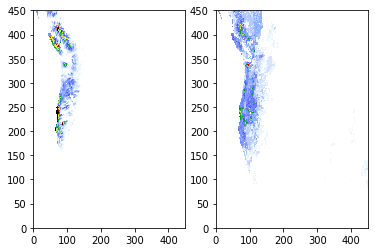

<Figure size 432x288 with 0 Axes>

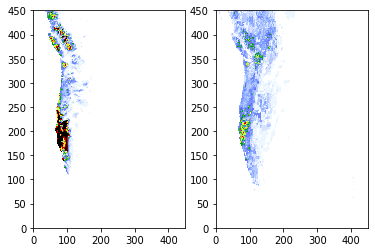

<Figure size 432x288 with 0 Axes>

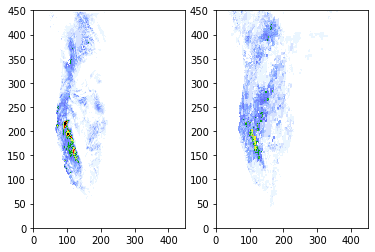

<Figure size 432x288 with 0 Axes>

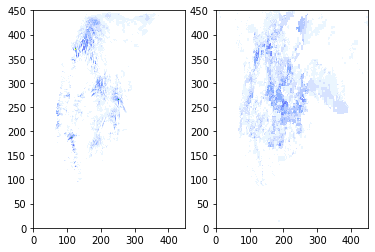

<Figure size 432x288 with 0 Axes>

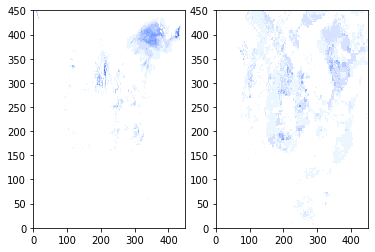

<Figure size 432x288 with 0 Axes>

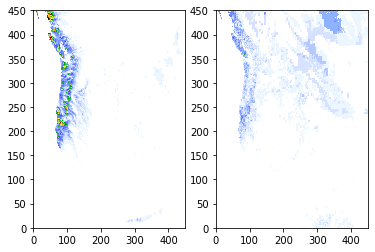

<Figure size 432x288 with 0 Axes>

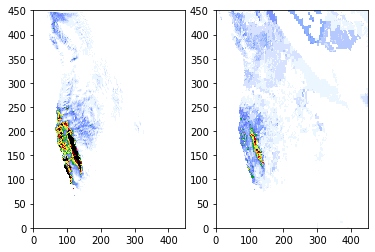

<Figure size 432x288 with 0 Axes>

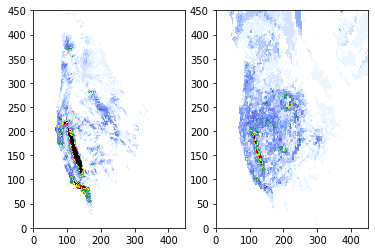

<Figure size 432x288 with 0 Axes>

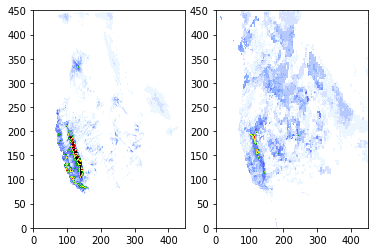

<Figure size 432x288 with 0 Axes>

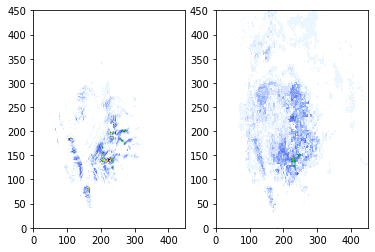

<Figure size 432x288 with 0 Axes>

In [31]:
for i in np.arange(20,30):
    
    true_map = recover_map_results(y_full[(i*landp_total):((i+1)*landp_total)], x_index, y_index)
    pred_map = recover_map_results(y_pred[(i*landp_total):((i+1)*landp_total)], x_index, y_index)

    fig1 = plt.figure()
    plt.subplot(1,2,1)
    plt.pcolormesh(true_map, cmap=crt_MeteoSwiss_colormap('precip2_17'), vmin=0, vmax=60)

    plt.subplot(1,2,2)
    plt.pcolormesh(pred_map, cmap=crt_MeteoSwiss_colormap('precip2_17'), vmin=0, vmax=60)

    plt.show()
    plt.clf()
    del(fig1)

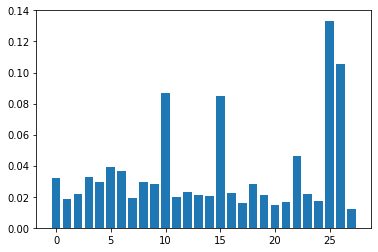

<Figure size 432x288 with 0 Axes>

In [32]:
plt.figure()
plt.bar(np.arange(28), regr_rf.feature_importances_)
plt.show()
plt.clf()